# Parametric umap autoencoder to visualize GAP layer data

## load GAP data

In [7]:
import torch
import math
import sys
import os

import numpy as np
import torchvision
import torchvision.transforms as transforms

In [2]:
INPUT_SIZE = 2048
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
content_path = "E:\\DVI_exp_data\\resnet50_cifar10"
sys.path.append(content_path)

from Model.model import resnet50
# net = resnet18()
net = resnet50()

cuda:0


In [13]:
path = os.path.join(content_path, "Model","Epoch_160", "subject_model.pth")
state_dict = torch.load(path)
net.load_state_dict(state_dict)
# load model
net.eval()
net.to(device)
print("Load Model successfully...")

Load Model successfully...


In [9]:
# hyperparameters
data_shape = (2048,)

ADD_NOISE = False
n_hidden = 500
dim_img = INPUT_SIZE  # number of pixels for a MNIST image
dim_z = 2

# train
n_epochs = 500
batch_size = 200
learn_rate = 0.001

In [5]:
# CIFAR10 Test dataset and dataloader declaration
CIFAR_NORM = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(*CIFAR_NORM)])

trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2000,
                                          shuffle=True, num_workers=2)
training_data = np.zeros((50000, 3, 32, 32))
for i, (data, target) in enumerate(trainloader, 0):
    r1, r2 = i * 2000, (i + 1) * 2000
    training_data[r1:r2] = data

raw_input_X = torch.from_numpy(training_data).to(device, dtype=torch.float)
input_X = np.zeros([len(raw_input_X), data_shape[0]])
n_batches = max(math.ceil(len(raw_input_X) / batch_size), 1)
for b in range(n_batches):
    r1, r2 = b * batch_size, (b + 1) * batch_size
    inputs = raw_input_X[r1:r2]
    with torch.no_grad():
        pred = model.gap(inputs).cpu().numpy()
        input_X[r1:r2] = pred
train_data = input_X    # (50000,2048)

train_data.shape

Files already downloaded and verified


(50000, 2048)

In [6]:
testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=2000,
                                          shuffle=True, num_workers=2)
testing_data = np.zeros((10000, 3, 32, 32))
for i, (data, target) in enumerate(testloader, 0):
    r1, r2 = i * 2000, (i + 1) * 2000
    testing_data[r1:r2] = data

raw_input_X = torch.from_numpy(testing_data).to(device, dtype=torch.float)
input_X = np.zeros([len(raw_input_X), data_shape[0]])
n_batches = max(math.ceil(len(raw_input_X) / batch_size), 1)
for b in range(n_batches):
    r1, r2 = b * batch_size, (b + 1) * batch_size
    inputs = raw_input_X[r1:r2]
    with torch.no_grad():
        pred = model.gap(inputs).cpu().numpy()
        input_X[r1:r2] = pred
test_data = input_X    # (10000,2048)

test_data.shape

Files already downloaded and verified


(10000, 2048)

In [12]:
train_data = np.load(os.path.join(content_path, "Model", "Epoch_160","train_data.npy"))

## load parametric umap

In [14]:
from parametric_umap import ParametricUMAP

In [21]:
# define encoder
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

dims = (2048,)
n_components = 2
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])
encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 2050      
Total params: 2,100,226
Trainable params: 2,100,226
Non-trainable params: 0
_________________________________________________________________


In [16]:
# define encoder
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

dims = (2048,)
n_components = 2

inputs = tf.keras.Input(shape=(n_components))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(units=1024, activation="relu")(x)
# x = tf.keras.layers.Dense(units=512, activation="relu")(x)
# x = tf.keras.layers.Dense(units=512, activation="relu")(x)
# x = tf.keras.layers.Dense(units=256, activation="relu")(x)
outputs = tf.keras.layers.Dense(units=n_components)(x)

encoder = tf.keras.Model(inputs, outputs)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              3072      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 5,122
Trainable params: 5,122
Non-trainable params: 0
_________________________________________________________________


In [22]:
# define the decoder
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
#     tf.keras.layers.Dense(units=256, activation="relu"),
#     tf.keras.layers.Dense(units=512, activation="relu"),
#     tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=1024, activation="relu"),
    tf.keras.layers.Dense(units=np.product(dims), name="recon", activation=None),
    tf.keras.layers.Reshape(dims),

])
decoder.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1024)              3072      
_________________________________________________________________
recon (Dense)                (None, 2048)              2099200   
_________________________________________________________________
reshape_1 (Reshape)          (None, 2048)              0         
Total params: 2,102,272
Trainable params: 2,102,272
Non-trainable params: 0
_________________________________________________________________


In [7]:
inputs = tf.keras.Input(shape=(n_components))

x = tf.keras.layers.Dense(units=1024, activation="relu")(inputs)
x = tf.keras.layers.Dense(units=np.product(dims), name="recon", activation="sigmoid")(x)
outputs = tf.keras.layers.Reshape(dims)(x)

decoder = tf.keras.Model(inputs, outputs)
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              3072      
_________________________________________________________________
recon (Dense)                (None, 2048)              2099200   
_________________________________________________________________
reshape (Reshape)            (None, 2048)              0         
Total params: 2,102,272
Trainable params: 2,102,272
Non-trainable params: 0
_________________________________________________________________


In [18]:
# optimizer = tf.keras.optimizers.Adam(1e-3)
batch_size = 1000

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 5:
        lr *= 1e-1
    elif epoch > 15:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

keras_fit_kwargs = {"callbacks": [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=10**-2,
        patience=10,
        verbose=1,
    ),
    tf.keras.callbacks.TensorBoard(log_dir='logs/mse/',histogram_freq=1),
    tf.keras.callbacks.LearningRateScheduler(lr_schedule),
    tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
]}

train_data.shape

(50000, 2048)

In [23]:
embedder = ParametricUMAP(
    encoder=encoder,
    decoder=decoder,
    dims=dims,
    parametric_reconstruction=True,
    optimizer = tf.keras.optimizers.Adam(1e-4),
#     reconstruction_validation=validation_data,
    autoencoder_loss=True,
    n_training_epochs=100,
    keras_fit_kwargs = keras_fit_kwargs,
    verbose=True,
)

## fit model

In [24]:
embedding = embedder.fit_transform(train_data)

ParametricUMAP(autoencoder_loss=True,
               decoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x000001D95CB1D6A0>,
               dims=(2048,),
               encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x000001D95C0608D0>,
               keras_fit_kwargs={'callbacks': [<tensorflow.python.keras.callbacks.EarlyStopping object at 0x000001D88C67EC50>,
                                               <tensorflow.python.keras.callbacks.ReduceLROnPlateau object at 0x000001D88C665588>]},
               n_training_epochs=100,
               optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D95C04EA58>,
               parametric_reconstruction=True)
Construct fuzzy simplicial set
Tue Aug  3 15:09:28 2021 Finding Nearest Neighbors
Tue Aug  3 15:09:28 2021 Building RP forest with 16 trees
Tue Aug  3 15:09:31 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iteration

## save model

In [19]:
import os

save_location = "parametric_umap_models\parametric_umap_autoencoder"
# # save encoder
encoder_output = os.path.join(save_location, "encoder")
embedder.encoder.save(encoder_output)
print("Keras encoder model saved to {}".format(encoder_output))

# # save decoder
decoder_output = os.path.join(save_location, "decoder")
embedder.decoder.save(decoder_output)
print("Keras decoder model saved to {}".format(decoder_output))


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: parametric_umap_models\parametric_umap_autoencoder\decoder\assets
Keras decoder model saved to parametric_umap_models\parametric_umap_autoencoder\decoder


In [20]:
# load encoder
encoder_output = os.path.join(save_location, "encoder")
if os.path.exists(encoder_output):
    load_encoder = tf.keras.models.load_model(encoder_output)
    print("Keras encoder model loaded from {}".format(encoder_output))

# load decoder
decoder_output = os.path.join(save_location, "decoder")
if os.path.exists(decoder_output):
    load_decoder = tf.keras.models.load_model(decoder_output)
    print("Keras decoder model loaded from {}".format(decoder_output))

Keras encoder model loaded from parametric_umap_models\parametric_umap_autoencoder\encoder
Keras decoder model loaded from parametric_umap_models\parametric_umap_autoencoder\decoder


## eval local structure preserving

### trustworthiness

In [21]:
from sklearn.manifold import trustworthiness

In [ ]:
train_embedded = embedder.transform(train_data)
t = trustworthiness(train_data, train_embedded, n_neighbors=10, metric='euclidean')
t

50/50 [==============================] - 0s 5ms/step


In [23]:
test_embedded = embedder.transform(test_data)
embedded_t = trustworthiness(test_data, test_embedded, n_neighbors=10, metric='euclidean')
embedded_t

10/10 [==============================] - 0s 6ms/step


0.9787051399669487

In [ ]:
total_data = np.concatenate((train_data, test_data),axis=0)
total_embedded = embedder.transform(total_data)
total_t = trustworthiness(total_data, total_embedded, n_neighbors=10, metric='euclidean')
total_t

60/60 [==============================] - 1s 19ms/step


50/50 [==============================] - 0s 5ms/step


Text(0.5, 1.0, 'parametric UMAP autoencoder embeddings-training data')

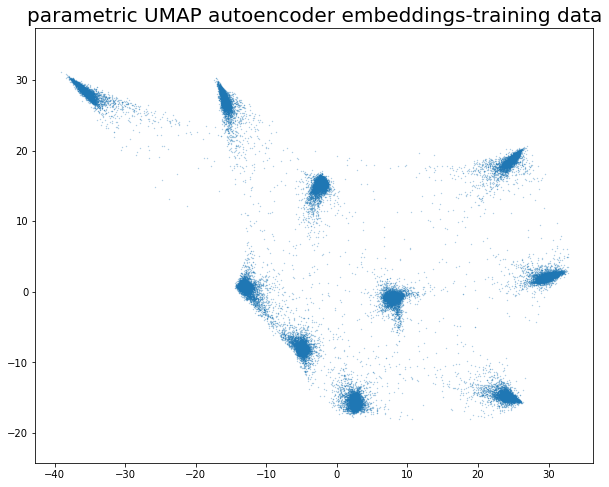

In [17]:
import matplotlib.pyplot as plt
# Project data
z = embedder.transform(train_data)
# z = load_encoder(train_data)

fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
#     c=train_labels,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("parametric UMAP autoencoder embeddings-training data", fontsize=20)

10/10 [==============================] - 0s 6ms/step


Text(0.5, 1.0, 'parametric UMAP autoencoder embeddings-testing data')

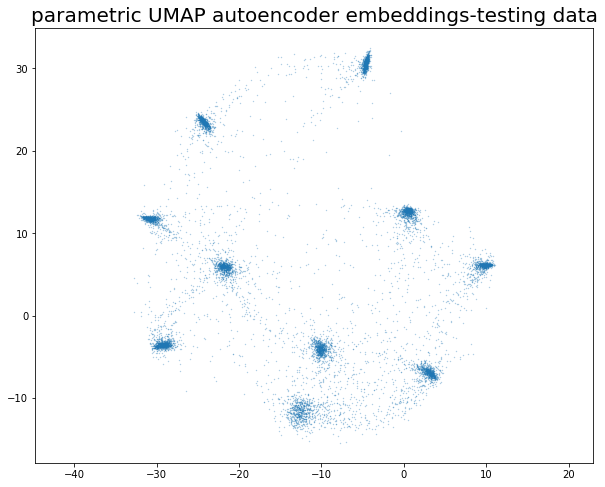

In [12]:
# Project data
z = embedder.transform(norm_test_data)

fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
#     c=train_labels,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("parametric UMAP autoencoder embeddings-testing data", fontsize=20)

In [ ]:
# Project data
z = embedder.transform(np.concatenate((train_data, test_data),axis=0))

fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
#     c=train_labels,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("parametric UMAP autoencoder embeddings-total data", fontsize=20)

## inverse

In [15]:
test_num = 4000
adv_succ_num = 400
adv_fail_num = 400
true_num = 1000

softmax = torch.nn.Softmax(dim=-1)

def pred_wrapper(x):
    with torch.no_grad():
        # tensor = torch.from_numpy(x).to(device, dtype=torch.float)
        logits = model.fc(x).cpu().numpy()
#         probabilities = softmax(logits).cpu().numpy()
    return logits

In [16]:
# ---------------------load data------------------------------
test_samples = training_data[:test_num]
true_samples = torch.from_numpy(testing_data[:true_num]).to(device, dtype=torch.float)

Adv_succ = np.load("adv_testset\\succ.npy")
Adv_fail = np.load("adv_testset\\fail.npy")

adv_succ = torch.from_numpy(Adv_succ[-adv_succ_num:]).to(device, dtype=torch.float)
adv_fail = torch.from_numpy(Adv_fail[-adv_fail_num:]).to(device, dtype=torch.float)

raw_input_X = torch.from_numpy(test_samples).to(device, dtype=torch.float)
raw_input_X = torch.cat((raw_input_X, adv_succ), axis=0)
raw_input_X = torch.cat((raw_input_X, adv_fail), axis=0)
raw_input_X = torch.cat((raw_input_X, true_samples), axis=0)

input_X = np.zeros([len(raw_input_X), data_shape[0]])
output_Y = np.zeros(len(raw_input_X))
n_batches = max(math.ceil(len(raw_input_X) / batch_size), 1)
for b in range(n_batches):
    r1, r2 = b * batch_size, (b + 1) * batch_size
    inputs = raw_input_X[r1:r2]
    with torch.no_grad():
        pred = model.gap(inputs).cpu().numpy()
        input_X[r1:r2] = pred
        pred = pred_wrapper(torch.from_numpy(pred).to(device, dtype=torch.float)).argmax(axis=1)
        output_Y[r1:r2] = pred
input_X.shape, output_Y.shape

((5800, 2048), (5800,))

In [17]:
embedded = embedder.transform(input_X)
y_PRR = embedder.inverse_transform(embedded)

6/6 [==============================] - 0s 10ms/step


In [18]:
# pick samples for training and testing
train_samples = input_X[:test_num]
train_labels = output_Y[:test_num]
test_adv_succ = input_X[test_num:test_num + adv_succ_num]
test_adv_succ_labels = output_Y[test_num:test_num + adv_succ_num]
test_adv_fail = input_X[test_num + adv_succ_num:test_num + adv_succ_num + adv_fail_num]
test_adv_fail_labels = output_Y[test_num + adv_succ_num:test_num + adv_succ_num + adv_fail_num]
test_true = input_X[-true_num:]
test_true_labels = output_Y[-true_num:]
# apply inverse mapping to embedded samples and
# predict the reconstructions
train_recon = y_PRR[:test_num]
train_recon_preds = pred_wrapper(torch.from_numpy(train_recon).to(device, dtype=torch.float)).argmax(axis=1)
train_confidence = pred_wrapper(torch.from_numpy(train_samples).to(device, dtype=torch.float)).max(axis=1)
train_new_confidence = pred_wrapper(torch.from_numpy(train_recon).to(device, dtype=torch.float)).max(axis=1)

adv_succ_recon = y_PRR[test_num:test_num + adv_succ_num]
adv_succ_recon_preds = pred_wrapper(torch.from_numpy(adv_succ_recon).to(device, dtype=torch.float)).argmax(
    axis=1)
adv_succ_confidence = pred_wrapper(torch.from_numpy(test_adv_succ).to(device, dtype=torch.float)).max(
    axis=1)
adv_succ_new_confidence = pred_wrapper(torch.from_numpy(adv_succ_recon).to(device, dtype=torch.float)).max(
    axis=1)

adv_fail_recon = y_PRR[test_num + adv_succ_num:test_num + adv_succ_num + adv_fail_num]
adv_fail_recon_preds = pred_wrapper(torch.from_numpy(adv_fail_recon).to(device, dtype=torch.float)).argmax(
    axis=1)
adv_fail_confidence = pred_wrapper(torch.from_numpy(test_adv_fail).to(device, dtype=torch.float)).max(
    axis=1)
adv_fail_new_confidence = pred_wrapper(torch.from_numpy(adv_fail_recon).to(device, dtype=torch.float)).max(
    axis=1)

true_recon = y_PRR[-true_num:]
true_recon_preds = pred_wrapper(torch.from_numpy(true_recon).to(device, dtype=torch.float)).argmax(axis=1)
true_confidence = pred_wrapper(torch.from_numpy(test_true).to(device, dtype=torch.float)).max(axis=1)
true_new_confidence = pred_wrapper(torch.from_numpy(true_recon).to(device, dtype=torch.float)).max(axis=1)

# calculate pred accuracy
n_correct = np.sum(train_labels == train_recon_preds)
train_acc = 100 * n_correct / test_num

n_correct = np.sum(test_adv_succ_labels == adv_succ_recon_preds)
test_adv_succ_acc = 100 * n_correct / float(adv_succ_num)

n_correct = np.sum(test_adv_fail_labels == adv_fail_recon_preds)
test_adv_fail_acc = 100 * n_correct / float(adv_fail_num)

n_correct = np.sum(test_true_labels == true_recon_preds)
test_true_acc = 100 * n_correct / float(true_num)

# calculate distance
train_distance = np.mean(np.sqrt(np.sum(np.square(train_samples - train_recon), axis=1)))
adv_succ_distance = np.mean(np.sqrt(np.sum(np.square(test_adv_succ - adv_succ_recon), axis=1)))
adv_fail_distance = np.mean(np.sqrt(np.sum(np.square(test_adv_fail - adv_fail_recon), axis=1)))
true_distance = np.mean(np.sqrt(np.sum(np.square(test_true - true_recon), axis=1)))

# calculate confidence difference
train_conf_diff = np.mean(np.abs(train_confidence - train_new_confidence))
adv_succ_conf_diff = np.mean(np.abs(adv_succ_confidence - adv_succ_new_confidence))
adv_fail_conf_diff = np.mean(np.abs(adv_fail_confidence - adv_fail_new_confidence))
true_conf_diff = np.mean(np.abs(true_confidence - true_new_confidence))

print("train acc:{:.2f}%, test_succ acc:{:.2f}%, test_fail acc:{:.2f}%, test_true acc:{:.2f}%".format(
    train_acc,
    test_adv_succ_acc,
    test_adv_fail_acc,
    test_true_acc))

print("train distance:{:.2f}, test_succ dis:{:.2f}, test_fail dis:{:.2f}, test_true dis:{:.2f}".format(
    train_distance,
    adv_succ_distance,
    adv_fail_distance,
    true_distance))
print(
    "train con diff:{:.2f}, test_succ con dif:{:.2f}, test_fail con diff:{:.2f}, test_true con diff:{:.2f}".format(
        train_conf_diff,
        adv_succ_conf_diff,
        adv_fail_conf_diff,
        true_conf_diff))

train acc:99.85%, test_succ acc:80.00%, test_fail acc:93.25%, test_true acc:98.20%
train distance:0.31, test_succ dis:2.03, test_fail dis:1.13, test_true dis:0.48
train con diff:0.11, test_succ con dif:0.79, test_fail con diff:0.40, test_true con diff:0.16


## Plot metric

### training loss

{'loss': [0.12639276683330536, 0.1037755087018013, 0.09784379601478577, 0.09377395361661911, 0.0918344184756279, 0.08966214209794998, 0.08765912055969238, 0.08596149832010269, 0.08532628417015076, 0.08519334346055984, 0.08466992527246475, 0.08426856994628906, 0.08333881199359894, 0.08281765878200531, 0.08285757899284363, 0.08234595507383347, 0.08177296072244644, 0.08119849860668182, 0.08117246627807617, 0.08090409636497498, 0.08089929074048996, 0.0805649608373642, 0.0801350474357605], 'reconstruction_loss': [0.001370985759422183, 0.0003683457034640014, 0.0002658352314028889, 0.0002367451088503003, 0.00025211117463186383, 0.00023992126807570457, 0.00015269662253558636, 0.0001307119382545352, 0.0001297822018386796, 0.0001274261885555461, 0.0001283742458326742, 0.0001277834817301482, 0.00012478503049351275, 0.00012207412510178983, 0.00011956294474657625, 0.00011651841487037018, 0.00011644230835372582, 0.00011594277020776644, 0.00011569943308131769, 0.00011471100151538849, 0.00011359199561

Text(0.5, 0, 'Epoch')

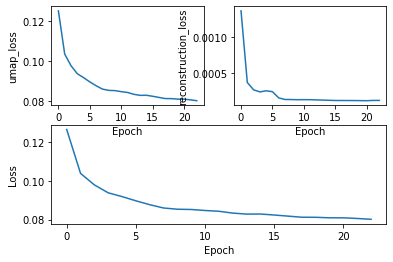

In [19]:
# plotting loss
import matplotlib.pyplot as plt
print(embedder._history)

# loss
ax1 = plt.subplot(212)
ax1.plot(embedder._history['loss'])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

#umap_loss
ax2 = plt.subplot(221)
ax2.plot(embedder._history['umap_loss'])
ax2.set_ylabel('umap_loss')
ax2.set_xlabel('Epoch')

# reconstruction loss
ax3 = plt.subplot(222)
ax3.plot(embedder._history['reconstruction_loss'])
ax3.set_ylabel('reconstruction_loss')
ax3.set_xlabel('Epoch')

### validation loss

Text(0.5, 0, 'Epoch')

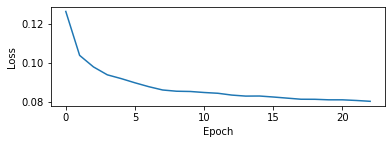

In [20]:
plt.cla()
# loss
ax1 = plt.subplot(212)
ax1.plot(embedder._history['loss'])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')


# reconstruction loss
# ax3 = plt.subplot(211)
# ax3.plot(embedder._history['val_reconstruction_loss'])
# ax3.set_ylabel('val_reconstruction_loss')
# ax3.set_xlabel('Epoch')

# load parametric umap

In [13]:
from deepview import DeepView


CIFAR_NORM = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
MAX_SAMPLES = 10000

# ---------------------choose device------------------------------
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")
print(device)

# ---------------------load models------------------------------
model = resnet50(pretrained=True)
model.eval()
model.to(device)
print("Load Model successfully...")

# ---------------------load dataset------------------------------
softmax = torch.nn.Softmax(dim=-1)

def pred_wrapper(x):
    with torch.no_grad():
        tensor = torch.from_numpy(x).to(device, dtype=torch.float)
        logits = model.fc(tensor).cpu().numpy()
#         probabilities = softmax(logits).cpu().numpy()
    return probabilities

def visualization(image, point2d, pred, label=None, title=None):
    f, a = plt.subplots()
    a.set_title(title)
    a.imshow(image.transpose([1, 2, 0]))

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# ---------------------deepview------------------------------
batch_size = 200
max_samples = MAX_SAMPLES + 2
data_shape = (2048,)
n = 5
lam = 0
resolution = 100
cmap = 'tab10'
title = 'ResNet-56 - CIFAR10 GAP layer (200 images)-parametric umap inverse'

X = np.load("D:\\xianglin\\git_space\\adversarial _gen\\adversary_samples\\fgsm_ex_0.npy")
Y = np.load("D:\\xianglin\\git_space\\adversarial _gen\\adversary_samples\\fgsm_labels_0.npy")
Y_true = np.array(torchvision.datasets.CIFAR10(root='data', train=False, download=True).targets)

test_num = 10000

x = torch.from_numpy(X[:test_num]).to(device, dtype=torch.float)
y = Y[:test_num, 1]

deepview = DeepView(pred_wrapper, classes, max_samples, batch_size,
                    data_shape, n, lam, resolution, cmap, title=title, data_viz=visualization,
                    metric="parametricUmap", encoder=encoder, decoder=decoder)

raw_input_X = x.clone()
input_X = np.zeros([len(raw_input_X), data_shape[0]])
n_batches = max(math.ceil(len(raw_input_X) / batch_size), 1)
for b in range(n_batches):
    r1, r2 = b * batch_size, (b + 1) * batch_size
    inputs = raw_input_X[r1:r2]
    with torch.no_grad():
        pred = model.gap(inputs).cpu().numpy()
        input_X[r1:r2] = pred

output_Y = np.array(y, copy=True)

print("prepare data...")

cpu
Load Model successfully...
Files already downloaded and verified
prepare data...


In [14]:
deepview.add_samples(input_X, output_Y)
deepview.show()

Embedding samples ...


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Cast: Dst tensor is not initialized. [Op:Cast]

# data augmentation

In [13]:
import torchvision.transforms as transforms
# Data augmentation and normalization for training
# Just normalization for validation
CIFAR_NORM = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomCrop(size=[32,32], padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(*CIFAR_NORM)
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*CIFAR_NORM)
    ]),
}

trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=data_transforms['train'])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=200,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=data_transforms['test'])
testloader = torch.utils.data.DataLoader(testset, batch_size=2000,
                                         shuffle=False, num_workers=2)

classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [7]:
print(model)
len(list(model.children()))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

10

In [14]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the network
# model = model.to(device)

# freeze front layers
ct = 0
for child in model.children():
    ct += 1
    if ct < 5:
        for param in child.parameters():
            param.requires_grad = False
model = model.to(device)
# model.eval()

CUDA Available:  True


## train

In [15]:
import torch.nn as nn
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=30)
criterion = nn.CrossEntropyLoss()

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [17]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    total = 0
    correct = 0
    
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        target = target.to(device)
        input = input.to(device)
        target_var = target

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # measure accuracy and record loss
        _, predicted = output.max(1)
        losses.update(loss.item(), input.size(0))
        total += target.size(0)
        correct += predicted.eq(target).sum().item()


        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 50 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Accuracy {acc:.3f}'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, acc=correct/total))

In [18]:
def save_checkpoint(state,filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

In [19]:
import time
global best_prec1
best_prec1 = 0

for epoch in range(50):

    # train for one epoch
    print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
    train(trainloader, model, criterion, optimizer, epoch)
    lr_scheduler.step()

#     if epoch > 0 and epoch % 50 == 0:
#         save_checkpoint({
#             'epoch': epoch + 1,
#             'state_dict': model.state_dict()
#         },  filename=os.path.join('parametric_umap_models/resnet50_data_augmentation', 'checkpoint2.th'))

#     save_checkpoint({
#         'state_dict': model.state_dict()
#     },  filename=os.path.join('parametric_umap_models/resnet50_data_augmentation', 'model2.th'))

current lr 1.00000e-02


RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 6.00 GiB total capacity; 3.85 GiB already allocated; 10.28 MiB free; 3.89 GiB reserved in total by PyTorch)